In [0]:
#| default_exp preprocessing.lesson_23

# Lesson 23 from fastai
> Lesson23 unet

In [0]:
#| hide
%load_ext autoreload
%autoreload 2

In [0]:
#| export
from cv_tools.core import *


In [110]:
#| export
import shutil,timm,os,torch,random,datasets,math
import fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
#import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from torchvision.io import read_image,ImageReadMode
from glob import glob

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.training import *

In [7]:
#| export
from fastprogress import progress_bar

In [9]:
torch.set_printoptions(
    precision=5,
    linewidth=140,
    sci_mode=False,
    )
set_seed(42)


In [17]:
#Path(os.getenv('DATA_PATH'), 'tiny_imagenet').mkdir(parents=True,exist_ok=True)
root_path = Path(os.getenv('DATA_PATH'),'tiny_imagenet')
path = root_path/'tiny-imagenet-200'
url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
if not path.exists():
    #path_zip = fc.urlsave(url, root_path)
    shutil.unpack_archive(root_path/'tiny-imagenet-200.zip', root_path)

In [20]:
data_path_ = Path(root_path,'tiny-imagenet-200')

In [38]:
#| export
class TinyDS:
	def __init__(self,path):
		self.path = Path(path)
		self.files = glob(str(path/'**/*.JPEG'),recursive=True)
	def __len__(self):
		return len(self.files)
	def __getitem__(self,idx):
		return self.files[idx], Path(self.files[idx]).parent.parent.name
	


In [28]:
Path(data_path_,'train').ls()

(#200) [Path('/home/hasan/Schreibtisch/projects/data/tiny_imagenet/tiny-imagenet-200/train/n04328186'),Path('/home/hasan/Schreibtisch/projects/data/tiny_imagenet/tiny-imagenet-200/train/n04149813'),Path('/home/hasan/Schreibtisch/projects/data/tiny_imagenet/tiny-imagenet-200/train/n02099712'),Path('/home/hasan/Schreibtisch/projects/data/tiny_imagenet/tiny-imagenet-200/train/n02788148'),Path('/home/hasan/Schreibtisch/projects/data/tiny_imagenet/tiny-imagenet-200/train/n04507155'),Path('/home/hasan/Schreibtisch/projects/data/tiny_imagenet/tiny-imagenet-200/train/n07583066'),Path('/home/hasan/Schreibtisch/projects/data/tiny_imagenet/tiny-imagenet-200/train/n04532670'),Path('/home/hasan/Schreibtisch/projects/data/tiny_imagenet/tiny-imagenet-200/train/n04487081'),Path('/home/hasan/Schreibtisch/projects/data/tiny_imagenet/tiny-imagenet-200/train/n04179913'),Path('/home/hasan/Schreibtisch/projects/data/tiny_imagenet/tiny-imagenet-200/train/n03970156')...]

In [39]:
tds = TinyDS(data_path_/'train')
tds[0]

('/home/hasan/Schreibtisch/projects/data/tiny_imagenet/tiny-imagenet-200/train/n04328186/images/n04328186_431.JPEG',
 'n04328186')

In [47]:
path_anno = path/'val'/'val_annotations.txt'
anno = dict(o.split('\t')[:2] for o in path_anno.read_text().splitlines())
anno['val_0.JPEG']

'n03444034'

In [48]:
class TinyValDS(TinyDS):
	def __getitem__(self,idx):
		return self.files[idx],anno[Path(self.files[idx]).name]

In [49]:
vds = TinyValDS(data_path_/'val')
vds[0]

('/home/hasan/Schreibtisch/projects/data/tiny_imagenet/tiny-imagenet-200/val/images/val_9059.JPEG',
 'n04465501')

In [50]:
len(tds)

100000

In [51]:
#| export
class TfmDS:
	def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop):
		self.ds, self.tfmx, self.tfmy = ds, tfmx, tfmy

	def __len__(self): return len(self.ds)
	def __getitem__(self,idx):
		x,y = self.ds[idx]
		return self.tfmx(x),self.tfmy(y)

In [52]:
id2str = (data_path_/'wnids.txt').read_text().splitlines()
str2id = {v:k for k,v in enumerate(id2str)}

In [58]:
# ImageNet stats
xmean,xstd = (tensor([0.47565, 0.40303, 0.31555]), tensor([0.28858, 0.24402, 0.26615]))

In [71]:
#| export
def tfmx(x):
	img = read_image(x,ImageReadMode.RGB)/255
	return (img - xmean[:,None,None])/xstd[:,None,None]

In [72]:
#| export
def tfmy(y): return tensor(str2id[y])

In [73]:
tfm_tds = TfmDS(tds,tfmx,tfmy)
tfm_vds = TfmDS(vds,tfmx,tfmy)
xi, yi = tfm_tds[0]
id2str[yi]

'n04328186'

In [83]:
#| export
def denorm(x):
	# remove imagenet stats
	return (x*xstd[:,None,None] + xmean[:,None,None]).clip(0,1)


(<Axes: >,)

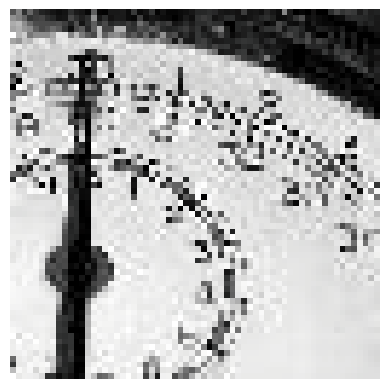

In [86]:
show_image(denorm(xi)),

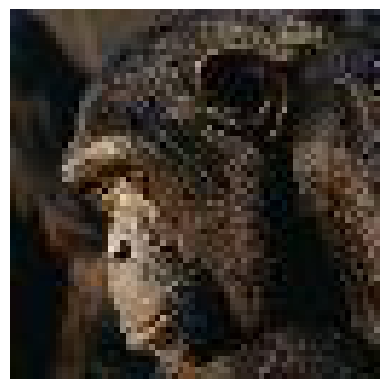

In [92]:
dltrn = DataLoader(
    tfm_tds, 
    batch_size=64, 
    shuffle=True,
    num_workers=8,
    #pin_memory=True,
    #drop_last=True,
    )
xb, yb = next(iter(dltrn))
show_image(denorm(xb[0]));


In [93]:
all_synsets = [o.split('\t') for o in (data_path_/'words.txt').read_text().splitlines()]
synsets = {k:v.split(',', maxsplit=1)[0] for k,v in all_synsets if k in id2str}

In [94]:
titles = [synsets[id2str[o]] for o in yb]
', '.join(titles[:20])

'chimpanzee, comic book, American lobster, maypole, pretzel, go-kart, bow tie, lemon, teapot, oboe, pizza, altar, reel, drumstick, scoreboard, vestment, guacamole, jellyfish, orange, espresso'

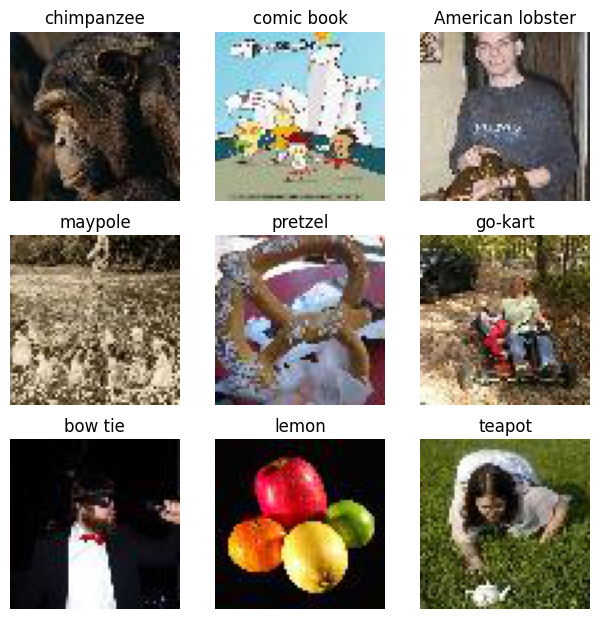

In [100]:
show_images((denorm(xb[:9])),titles=titles[:9], imsize=2.5)

In [113]:
DataLoaders?

Init signature: DataLoaders(*dls)
Docstring:      <no docstring>
File:           ~/Schreibtisch/projects/git_data/course22p2/miniai/datasets.py
Type:           type
Subclasses:     

In [104]:
dls = DataLoaders(*get_dls(tfm_tds,tfm_vds,bs=64, num_workers=8))

# Augmentation After dataloader creation

In [114]:
#| export
def tfm_batch(b, tfmx=fc.noop, tfmy=fc.noop):
	return tfmx(b[0]),tfmy(b[1])


In [115]:
#| export
tfms = nn.Sequential(
	T.Pad(4),
	T.RandomHorizontalFlip(),
	RandErase())
augcb = BatchTransformCB(
    partial(tfm_batch, tfmx=tfms), on_val=False)


In [116]:
#| export
act_gr = partial(
    GeneralRelu, 
    leak=0.1, 
    sub=0.4)
iw = partial(
	init_weights, leaky=0.1)

In [121]:
#| export
def generate_resblock_mermaid_diagram():
    """
    Generates a Mermaid diagram for the ResBlock architecture.

    Returns:
        str: The Mermaid diagram code for the ResBlock architecture.
    """
    diagram_code = """
    graph LR
    A[Input] --> B[Conv Block]
    B --> C[Identity Connection]
    B --> D[Pool]
    C --> E[Add]
    D --> E
    E --> F[Activation]
    F --> G[Output]
    """
    return diagram_code

#| export
def visualize_mermaid_diagram(diagram_code):
    """
    Visualizes a Mermaid diagram.

    Args:
        diagram_code (str): The Mermaid diagram code.

    Returns:
        IPython.display.DisplayObject: The visualized Mermaid diagram.
    """
    from IPython.display import DisplayObject, display
    display_object = DisplayObject()
    display_object.data = {'text/plain': diagram_code}
    display_object.metadata = {'application/mermaid': {'code': diagram_code}}
    display(display_object)

#| export
def visualize_resblock_diagram():
    """
    Visualizes the ResBlock Mermaid diagram.
    """
    diagram_code = generate_resblock_mermaid_diagram()
    visualize_mermaid_diagram(diagram_code)




In [118]:
nfs = (32,64,128,256,512, 1024)
		


In [129]:
# ResBlock: Two convolutional layers with a shortcut connection (identity connection and optional pooling)
# %% ../nbs/13_resnet.ipynb 14
def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    """
    Creates a convolutional block with two convolutional layers.

    Args:
        ni (int): Number of input channels.
        nf (int): Number of output channels.
        stride (int): Stride for the convolutional layers.
        act (function, optional): Activation function. Defaults to act_gr.
        norm (function, optional): Normalization function. Defaults to None.
        ks (int, optional): Kernel size for the convolutional layers. Defaults to 3.

    Returns:
        nn.Sequential: The convolutional block.
    """
    return nn.Sequential(conv(ni, nf, stride=1, act=act, norm=norm, ks=ks),
                         conv(nf, nf, stride=stride, act=None, norm=norm, ks=ks))

class ResBlock(nn.Module):
    """
    Residual Block in a ResNet architecture.

    Args:
        ni (int): Number of input channels.
        nf (int): Number of output channels.
        stride (int, optional): Stride for the convolutional layers. Defaults to 1.
        ks (int, optional): Kernel size for the convolutional layers. Defaults to 3.
        act (function, optional): Activation function. Defaults to act_gr.
        norm (function, optional): Normalization function. Defaults to None.
    """
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride, act=act, ks=ks, norm=norm)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
        self.act = act()

    def forward(self, x):
        """
        Forward pass of the ResBlock.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        return self.act(self.convs(x) + self.idconv(self.pool(x)))

In [142]:
#| export
def get_dropout_model(
        act=act_gr,
		nfs=nfs,
		norm=nn.BatchNorm2d,
		drop=0.1):
	"Create a resnet with dropout model"
	layers = [nn.Conv2d(3, nfs[0], 5, padding=2)]
	layers += [ResBlock(nfs[i], nfs[i+1], stride=2, act=act, norm=norm) for i in range(len(nfs)-1)]
	layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
	layers += [nn.Linear(nfs[-1], 200, bias=False), nn.BatchNorm1d(200)]
	return nn.Sequential(*layers).apply(iw)





In [143]:
learn = TrainLearner(
    model=get_dropout_model(),
	dls=dls,
	loss_func=F.cross_entropy,
	cbs=[SingleBatchCB(), augcb, DeviceCB()],
	
)
learn.fit(1)

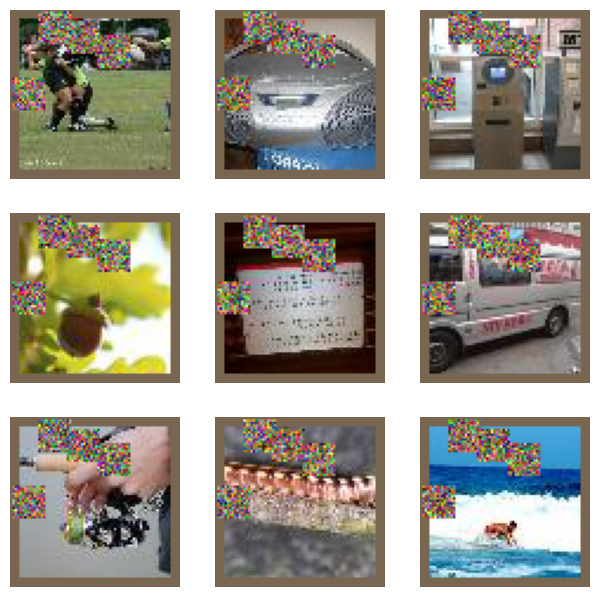

In [150]:
xb, yb = learn.batch
show_images(denorm(xb.cpu())[:9],imsize=2.5)

In [145]:
learn.summary()

Tot params: 19775824; MFLOPS: 459.5


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Conv2d|(64, 3, 72, 72)|(64, 32, 72, 72)|2432|12.4|
|ResBlock|(64, 32, 72, 72)|(64, 64, 36, 36)|57792|74.3|
|ResBlock|(64, 64, 36, 36)|(64, 128, 18, 18)|230272|74.3|
|ResBlock|(64, 128, 18, 18)|(64, 256, 9, 9)|919296|74.3|
|ResBlock|(64, 256, 9, 9)|(64, 512, 5, 5)|3673600|91.8|
|ResBlock|(64, 512, 5, 5)|(64, 1024, 3, 3)|14687232|132.1|
|AdaptiveAvgPool2d|(64, 1024, 3, 3)|(64, 1024, 1, 1)|0|0.0|
|Flatten|(64, 1024, 1, 1)|(64, 1024)|0|0.0|
|Dropout|(64, 1024)|(64, 1024)|0|0.0|
|Linear|(64, 1024)|(64, 200)|204800|0.2|
|BatchNorm1d|(64, 200)|(64, 200)|400|0.0|


In [151]:
opt_func = partial(optim.AdamW, eps=1e-5)

In [152]:
lr_cbs = [DeviceCB(),augcb, MixedPrecision(), ProgressCB()]

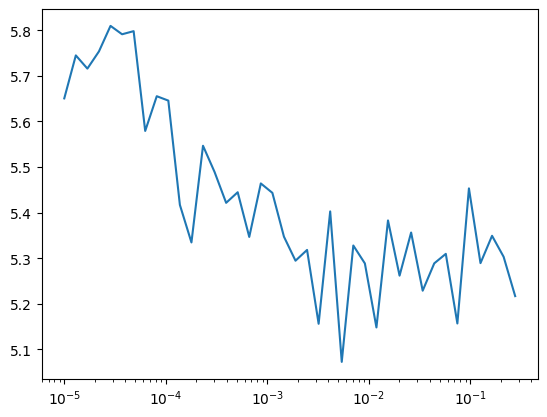

In [154]:
learn = Learner(
    model=get_dropout_model(),
	dls=dls,
	loss_func=F.cross_entropy,
	cbs=lr_cbs,
	opt_func=opt_func,
)
learn.lr_find()

In [155]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(),metrics, MixedPrecision(), ProgressCB(plot=True)]

epochs = 25
lr =0.1
tmax = epochs*len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
learn = Learner(
    model=get_dropout_model(),
	dls=dls,
	loss_func=F.cross_entropy,
	cbs=cbs+xtra,
	opt_func=opt_func,
)


accuracy,loss,epoch,train
0.053,4.738,0,train
0.071,5.856,0,eval
0.106,nan,1,train
0.005,nan,1,eval
0.005,nan,2,train
0.005,nan,2,eval
0.005,nan,3,train
0.005,nan,3,eval


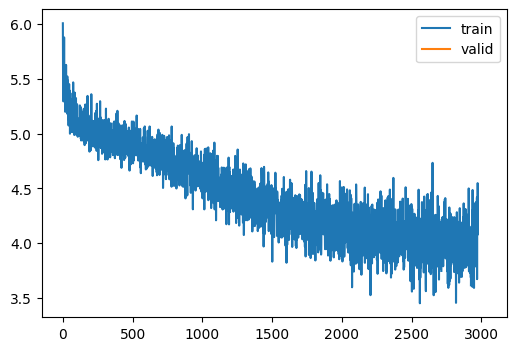

KeyboardInterrupt: 

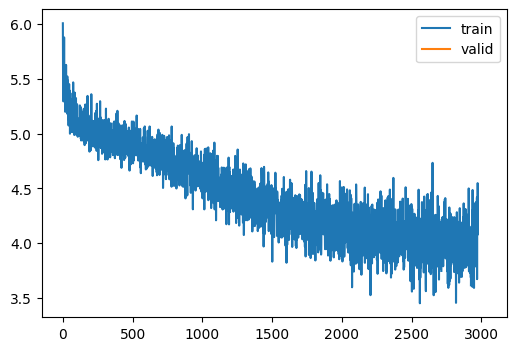

In [156]:

learn.fit(epochs)


In [157]:
class GradientClipping(Callback):
    def __init__(self, clip=1.0):
        self.clip = clip
    
    def after_backward(self, learn):
        if learn.loss.isnan().any():
            print(f"NaN loss detected! Skipping batch.")
            learn.loss = torch.tensor(0.0, device=learn.loss.device)
            return
        torch.nn.utils.clip_grad_norm_(learn.model.parameters(), self.clip)

In [158]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(),metrics, MixedPrecision(), ProgressCB(plot=True)]

epochs = 25
lr =0.1
tmax = epochs*len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb, GradientClipping(1.0)]
learn = Learner(
    model=get_dropout_model(),
	dls=dls,
	loss_func=F.cross_entropy,
	cbs=cbs+xtra,
	opt_func=opt_func,
)


In [163]:
bs = 128

accuracy,loss,epoch,train
0.138,4.667,0,train
0.115,4.587,0,eval
0.151,4.677,1,train
0.123,4.669,1,eval
0.156,4.726,2,train
0.075,4.821,2,eval
0.161,4.806,3,train
0.013,5.266,3,eval
0.114,5.027,4,train
0.012,5.299,4,eval


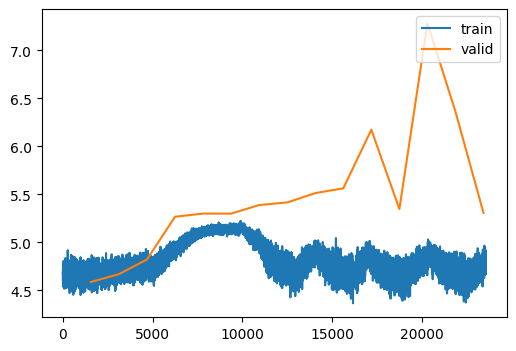

In [162]:

learn.fit(epochs)


In [ ]:

learn.recorder.plot_loss()
learn.recorder.plot_metrics()
learn.recorder.plot_lr()
learn.recorder.plot_metrics()


# Deeper [in actual resnet used]

In [ ]:
def res_blocks(
        n_bk,
		ni,
		nf,
		stride=1,
		ks=3,
		act=act_gr,
		norm=None,
		):
	return nn.Sequential(
		*[ResBlock(
			ni if i==0 else nf,
			nf stride=stride if i ==n_bk-1 else 1,
			ks=ks, 
			act=act, 
			norm=norm) for _ in range(n_bk)])


In [ ]:
nbks = (3, 2,2, 1, 1)

In [ ]:
def get_dropmodel(
        act=act_gr,
		nfs=nfs,
		nbks=nbks,
		norm=nn.BatchNorm2d,
		drop=0.2,
		):
	layers = [ResBlock(3, nfs[0],ks=5,stride=1, act=act, norm=norm)]
	layers+= [res_blocks(nbks[i], nfs[i], nfs[i+1], stride=2, act=act, norm=norm) for i in range(len(nfs)-1)]
	layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
	layers += [nn.Linear(nfs[-1], 200, bias=False), nn.BatchNorm1d(200)]
	return nn.Sequential(*layers).apply(iw)

learn = Learner(
	
)


In [ ]:
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, cbs=[SingleBatchCB(), augcb, DeviceCB()])
learn.fit(1)
xb,yb = learn.batch
show_images(denorm(xb.cpu())[:9], imsize=2.5)

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), MixedPrecision()]

epochs = 25
lr = 3e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb, GradientClipping(1.0)]
learn = Learner(get_dropmodel(), dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

> More Augmenation (Trivial Augmentation) not batch wise augmentation but sample wise augmentation

> PreActivation Resnet

In [6]:
#| hide
import nbdev; nbdev.nbdev_export('06_preprocessing.lesson_23.ipynb')